In [1]:
# !pip uninstall --y dgl-cu101
# !pip install --pre --quiet dgl-cu101
# !conda install -c dglteam dgl-cuda10.1

In [2]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import dgl.function as Fn
from functools import partial
import seaborn as sns
import pickle
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
# import tsne_func

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

data_dir="/workspace/cjiang/eagle_project/CAP_graph/dataset/"
root_dir="/workspace/cjiang/eagle_project/CAP_graph/"

os.chdir(root_dir)

print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

torch version is 1.9.0+cu102
DGL version is 0.8a210818


In [3]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [4]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_v1'), 'rb') as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 5.0030 seconds to load graph


In [5]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)
usaanr_feat=[x for x in usaanr_feat if x not in ['usaanr','cmpyelig','ACTCORP','Segment']]
usaanr_feat

['usaayr',
 'AGE_BAND',
 'ORIGEL',
 'ELIG2',
 'SEX',
 'MARST',
 'BRANCH',
 'ENLPAYGD',
 'MILST',
 'MLIST_OrigStat',
 'STATE']

In [6]:
class graph_2_df:
    def __init__(self,g):
        
        self.g=g
        
    def df_creation(self):
        usaanr_feat=[]
        for key, scheme in self.g.node_attr_schemes(ntype="usaanr").items():
            usaanr_feat.append(key)
        usaanr_feat=[x for x in usaanr_feat if x not in ['usaanr','cmpyelig','ACTCORP','Segment']]
        
        DF=pd.DataFrame()
        for i,col in enumerate(usaanr_feat):
            ndata=self.g.nodes['usaanr'].data[col].squeeze().numpy()
            DF[col]=ndata
        
        class_le=LabelEncoder()

        for i in tqdm(range(len(DF.columns)),position=0,leave=True):
            col=DF.columns[i]

            DF[col]=class_le.fit_transform(DF[col])
            DF[col]=DF[col].astype('str')
                
        return DF

DF=graph_2_df(G).df_creation()


100%|██████████| 11/11 [02:57<00:00, 16.17s/it]


In [15]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()),2)
    return gain

def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def eval_loop_func(model, test_dl):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses=[]
    for df,lbl in tqdm(test_dl, position=0, leave=True):
        logits,h = model(df)

        loss = F.cross_entropy(logits, lbl.long().squeeze(1))
        
        fin_targets.append(lbl.squeeze().cpu().detach().numpy())
        fin_outputs.append(logits.cpu().detach().numpy())
        
    return np.concatenate(fin_outputs), np.concatenate(fin_targets)

def evaluate(target, predicted):
    true_label_mask=[1 if (np.argmax(x)-target[i])==0 else 0 for i,x in enumerate(predicted)]
    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    precision, recall, fscore, support = precision_recall_fscore_support(target, predicted.argmax(axis=1))
    auc = roc_auc_score(target.ravel(), torch.sigmoid(torch.from_numpy(predicted))[:,1].numpy().ravel())
    
    prec,rec,_ = precision_recall_curve(target.ravel(), torch.sigmoid(torch.from_numpy(predicted))[:,1].numpy().ravel())
    
    pr_auc=auc_score(rec,prec)
    
    arg1=predicted[:,1]
    arg2=target
    gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":precision[1], 
        "recall":recall[1], 
        "f1_score":fscore[1],
        "AUC":auc,
        "pr_auc":pr_auc,
        "GAIN":gain
    }

In [23]:
y=binary_label.squeeze().numpy()
num_classes=th.unique(binary_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
# imbalance_classes["category"]=torch.unique(binary_label).tolist()
imbalance_classes["Auto or Not"]=["No","Yes"]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,Auto or Not,count,weight
0,No,"19,358,913",0.66
1,Yes,"6,309,591",2.03


Text(0.5, 1.0, 'Distribution of Target Variables')

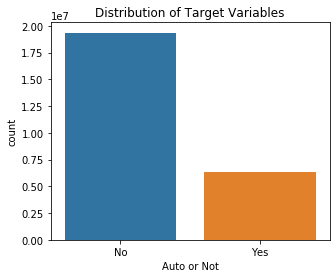

In [10]:
import seaborn as sns
sns.barplot(x="Auto or Not",y="count",data=imbalance_classes)
plt.title("Distribution of Target Variables")

In [12]:
train_idx=th.nonzero(train_mask_binary_label.squeeze()).numpy()
val_idx=th.nonzero(val_mask_binary_label.squeeze()).numpy()
test_idx=th.nonzero(test_mask_binary_label.squeeze()).numpy()

train_idx=th.from_numpy(train_idx).squeeze()    
val_idx=th.from_numpy(val_idx).squeeze()    
test_idx=th.from_numpy(test_idx).squeeze()

label_train=binary_label[train_idx].squeeze().numpy()
label_val=binary_label[val_idx].squeeze().numpy()
label_test=binary_label[test_idx].squeeze().numpy()

df_train=DF.loc[train_idx,:]
df_val=DF.loc[val_idx,:]
df_test=DF.loc[test_idx,:]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [13]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,vertices_feat,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.vertices_feat=vertices_feat
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(self.vertices_feat[col].unique().max()+1, feature_size)
    
    def forward(self,X):
        X=X.to("cpu")
        extra_repr=[]
        for i,col in enumerate(usaanr_feat):
            ndata=X[:,i]
            extra_repr.append(self.emb[col](ndata).squeeze())
        return th.stack(extra_repr, 0).sum(0)

In [21]:
class MLP(nn.Module):
    def __init__(self,
                 df_train,
                 h_dim,
                 out_dim,
                 num_hidden_layers,
                 dropout=0):
        super(MLP, self).__init__()
        self.df=df_train
        self.h_dim=h_dim
        self.out_dim=out_dim
        self.num_hidden_layers=num_hidden_layers
        self.dropout=dropout

        self.usaanr_node_embed=USAANR_Embedding(self.df,self.h_dim)

    #     self.layers = nn.ModuleList()

        #i2h
        self.hidden1=nn.Linear(self.h_dim,self.h_dim)
        nn.init.xavier_uniform_(self.hidden1.weight, gain=nn.init.calculate_gain('relu'))
        self.act1 = nn.ReLU()

        # h2h
        if self.num_hidden_layers>1:
            self.hidden2=nn.Linear(self.h_dim,self.h_dim)
            nn.init.xavier_uniform_(self.hidden2.weight, gain=nn.init.calculate_gain('relu'))
            self.act2 = nn.ReLU()

        # h2o
        self.hidden3=nn.Linear(self.h_dim,self.out_dim)
        nn.init.xavier_uniform_(self.hidden3.weight, gain=nn.init.calculate_gain('relu'))
#         self.act3 = nn.Sigmoid()
    
    def forward(self, X):
        H=self.usaanr_node_embed(X)
        H=self.hidden1(H)
        H=self.act1(H)
        
         # second hidden layer
        H = self.hidden2(H)
        H = self.act2(H)
        # third hidden layer and output
        output = self.hidden3(H)
#         output = self.act3(H)
        return output, H

In [16]:
#### Dataset definition
class Batch_Dataset(Dataset):
    def __init__(self,df,label):
        self.x=df.values
        # ensure input data is floats
        self.x = self.x.astype('int')
        self.y=label
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.x)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]


#### settings

In [17]:
parser = argparse.ArgumentParser(description='MLP')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=2,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--num_layers", type=int, default=2,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")
parser.add_argument("--batch_size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--validation",  default=True,
        help="set up validation .")
parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")
parser.add_argument("--weight",  type=float,default=46,  ## number of label=0/number of label=1
        help="weight for unbalance data")
parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 

args,unknown=parser.parse_known_args()


In [18]:
args.n_epochs=1
args.h_dim=64
args.num_layers=2
args.lr=1e-3
args.l2norm=1e-3
print(args)

Namespace(batch_size=1024, dropout=0, gpu=0, h_dim=64, l2norm=0.001, lr=0.001, n_epochs=1, num_layers=2, num_mini_batch=8, num_worker=0, out_dim=2, seed=101, validation=True, weight=46)


In [19]:
train=Batch_Dataset(df_train,label_train)
val=Batch_Dataset(df_val,label_val)
test=Batch_Dataset(df_test,label_test)

train_dl = DataLoader(train, batch_size=args.batch_size, shuffle=False)
val_dl = DataLoader(val, batch_size=args.batch_size, shuffle=False)
test_dl = DataLoader(test, batch_size=args.batch_size, shuffle=False)

print('{:<20} {:<10,}'.format("Train loader",len(train_dl)))
print('{:<20} {:<10,}'.format("validation loader",len(val_dl)))
print('{:<20} {:<10,}'.format("test loader",len(test_dl)))

Train loader         20,054    
validation loader    2,507     
test loader          2,507     


In [20]:
##### check cuda
device="cpu"
# if th.cuda.is_available():
#     th.cuda.set_device(0)
#     device='cuda'
print(device)

cpu


In [24]:
# create model
model = MLP(df_train,
            args.h_dim,
            num_classes,
            args.num_layers,
            dropout=args.dropout)

# if th.cuda.is_available():
#     model.cuda()

print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )
print()
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

TypeError: must be str, not int

In [18]:
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)

In [19]:
# %pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]
ACC_EPOCH=[]
# training loop
print("start training...")
dur = []
total_loss=0
losses=[]



# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True


for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    LABEL=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (df_train, labels_train) in enumerate(train_dl):

        logits,h = model(df_train)
        optimizer.zero_grad()
#         loss = F.cross_entropy(logits, labels_train.long().squeeze(1),weight=th.Tensor([1,args.weight]))
        loss = F.cross_entropy(logits, labels_train.long().squeeze(1))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        train_acc = th.sum(logits.argmax(dim=1) == labels_train.squeeze(1)).item() / labels_train.shape[0]
        
        tempt=labels_train.detach().cpu().numpy()
        labels_train_one_hot=np.zeros(shape=(tempt.shape[0],8),dtype=np.float32)
        labels_train_one_hot[np.arange(tempt.shape[0]),np.array([ele.astype(int).item() for ele in tempt])]=1
        train_auc = roc_auc_score(labels_train_one_hot.ravel(), th.sigmoid(logits).detach().cpu().numpy().ravel())    
        
#         Since loader is created without shuffle, we don't need to create IDX for the ordering        
#         IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        LABEL.extend(labels_train.long().squeeze(1).tolist())
        
        if step%(len(train_dl)//10)==0 and not step==0:
            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Accuracy {:.2%} | ROC_AUC {:.2%}  | Elapsed: {:}".\
                  format(step,len(train_dl),np.mean(losses[-10:]),train_acc,train_auc,elapsed))   
            
    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    
    acc_train, loss_train, train_auc = evaluate(model, train_dl)
    
    t2=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%} | ROC_AUC: {:.2%}  | Elapsed: {:}"\
      .format(loss_train, acc_train,  train_auc, utils.format_time(t2-t1)))
            

    #====================================#
    #            Validation-set          #
    #====================================#
    model.eval()
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    
    acc_val, loss_val, val_auc = evaluate(model, val_dl)
    
    t3=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%} | ROC_AUC: {:.2%}  | Elapsed: {:}"\
      .format(loss_val, acc_val,  val_auc, utils.format_time(t3-t2)))

    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

acc_test, loss_test, test_auc= evaluate(model, test_dl)

t4=time.time()
print("loss: {:.3f} |  Accuracy {:.2%} | ROC_AUC: {:.2%} | Elapsed: {:}"\
      .format(loss_test, acc_test, test_auc, utils.format_time(t4-t3)))


  0%|          | 0/1 [00:00<?, ?it/s]

start training...

========= Epoch 1 /1
Training...
Batch 2178 of 21785 | Loss 0.268  | Accuracy 90.33% | ROC_AUC 99.20%  | Elapsed: 0:04:50
Batch 4356 of 21785 | Loss 0.271  | Accuracy 88.28% | ROC_AUC 99.20%  | Elapsed: 0:09:34
Batch 6534 of 21785 | Loss 0.266  | Accuracy 89.26% | ROC_AUC 99.18%  | Elapsed: 0:14:20
Batch 8712 of 21785 | Loss 0.267  | Accuracy 87.99% | ROC_AUC 99.05%  | Elapsed: 0:19:08
Batch 10890 of 21785 | Loss 0.186  | Accuracy 91.11% | ROC_AUC 99.51%  | Elapsed: 0:23:51
Batch 13068 of 21785 | Loss 0.152  | Accuracy 95.21% | ROC_AUC 99.79%  | Elapsed: 0:29:00
Batch 15246 of 21785 | Loss 0.145  | Accuracy 95.51% | ROC_AUC 99.83%  | Elapsed: 0:33:55
Batch 17424 of 21785 | Loss 0.135  | Accuracy 95.31% | ROC_AUC 99.82%  | Elapsed: 0:39:09
Batch 19602 of 21785 | Loss 0.110  | Accuracy 94.34% | ROC_AUC 99.84%  | Elapsed: 0:44:01
Batch 21780 of 21785 | Loss 0.041  | Accuracy 99.41% | ROC_AUC 99.99%  | Elapsed: 0:49:19


  0%|          | 1/21785 [00:00<36:23,  9.98it/s]



Running Validation on training set



  0%|          | 5/2724 [00:00<01:06, 41.09it/s]

loss: 0.270 |  Accuracy 89.67% | ROC_AUC: 99.15%  | Elapsed: 0:12:57


Running Validation on validation set



  0%|          | 5/2724 [00:00<01:05, 41.49it/s]

loss: 0.270 |  Accuracy 89.69% | ROC_AUC: 99.15%  | Elapsed: 0:01:45


Running Validation in Test Dataset



100%|██████████| 2724/2724 [01:19<00:00, 34.17it/s]

loss: 0.270 |  Accuracy 89.66% | ROC_AUC: 99.15% | Elapsed: 0:01:20


In [20]:
# model.node_embed['House_Properties'].emb['STD_LOC_DC'].weight

#### sparsity rate of embedding vector

In [21]:
np.array(H).shape

(22307469, 64)

In [22]:
H=np.array(H)
non_zero=np.count_nonzero(H)
total_val=np.product(H.shape)
sparsity=(total_val-non_zero)/total_val
density=non_zero/total_val
print("sparsity rate is {:.2%}".format(sparsity))
print("density rate is {:.2%}".format(density))
print("embedding vector shape is {}".format(H.shape))

sparsity rate is 40.86%
density rate is 59.14%
embedding vector shape is (22307469, 64)


In [23]:
H_train=np.array(H)
LABEL_train=np.array(LABEL)
mask_train=np.array(['train']*len(H_train))

In [24]:
H_val=[]
LABEL_val=[]
for df_val, labels_val in tqdm(val_dl, position=0, leave=True):
    model.eval()
    logits,h = model(df_val)
    H_val.extend(h.detach().cpu().numpy().tolist())
    LABEL_val.extend(labels_val.long().squeeze(1).tolist())
    
H_val=np.array(H_val)
LABEL_val=np.array(LABEL_val)
mask_val=np.array(['val']*len(H_val))

100%|██████████| 2724/2724 [01:20<00:00, 33.78it/s]


In [25]:
H_test=[]
LABEL_test=[]
for df_test, labels_test in tqdm(test_dl, position=0, leave=True):
    model.eval()
    logits,h = model(df_test)
    H_test.extend(h.detach().cpu().numpy().tolist())
    LABEL_test.extend(labels_test.long().squeeze(1).tolist())
    
H_test=np.array(H_test)
LABEL_test=np.array(LABEL_test)
mask_test=np.array(['test']*len(H_test))

100%|██████████| 2724/2724 [01:34<00:00, 28.79it/s]


In [26]:
embedding_vector=np.concatenate((H_train,H_val, H_test))
LABEL=np.concatenate((LABEL_train,LABEL_val, LABEL_test))
mask=np.concatenate((mask_train,mask_val, mask_test))

print("{:<30}{}".format("shape of embedding vector",embedding_vector.shape))
print("{:<30}{}".format("shape of LABEL",LABEL.shape))

shape of embedding vector     (27884332, 64)
shape of LABEL                (27884332,)


#### visualization of embedding vectors for different categories of USAA Members

In [27]:
DF=pd.DataFrame({"MASK":mask.tolist(), "Product":LABEL.squeeze().tolist()})
prod_map={0:"No_Product",1:"Rental_only",2:"Home_only",3:"Home+Rental",4:"Auto_only",5:"Auto+Rental",6:"Auto+Home",7:"Auto+Home+Rental"}
DF['Product'] = list(map(prod_map.get, DF['Product']))

### the caterogry of "Home+Rental" is too rare, only 2767 in total. So remove it.
inx=np.where(DF["Product"].values!="Home+Rental")[0]
DF=DF[DF["Product"]!="Home+Rental"]
embedding_vector=embedding_vector[inx]
DF["IDX"]=np.arange(DF.shape[0])  ## Reindex the DF since the caterogry of "Home+Rental" has been removed

N=1000

train_df=DF[DF["MASK"]=="train"]
sample_df_train=train_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_train=sample_df_train["IDX"].values
prod_sample_train=DF['Product'].values[sample_id_train]
embedding_sample_train=embedding_vector[sample_id_train]

val_df=DF[DF["MASK"]=="val"]
sample_df_val=val_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_val=sample_df_val["IDX"].values
prod_sample_val=DF['Product'].values[sample_id_val]
embedding_sample_val=embedding_vector[sample_id_val]

test_df=DF[DF["MASK"]=="test"]
sample_df_test=test_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_test=sample_df_test["IDX"].values
prod_sample_test=DF['Product'].values[sample_id_test]
embedding_sample_test=embedding_vector[sample_id_test]

In [28]:
%%time
print("t-SNE dimension reduction for training embedding vector:")
print()
train_embedding = tsne_func.fit(embedding_sample_train)


t-SNE dimension reduction for training embedding vector:

[t-SNE] Iteration 100: error = 2.0685973, gradient norm = 0.0008850
[t-SNE] Iteration 200: error = 1.6117158, gradient norm = 0.0003184
[t-SNE] Iteration 300: error = 1.4382269, gradient norm = 0.0001901
[t-SNE] Iteration 400: error = 1.3501349, gradient norm = 0.0001217
[t-SNE] Iteration 500: error = 1.2962123, gradient norm = 0.0000865
[t-SNE] Iteration 600: error = 1.2581484, gradient norm = 0.0000961
[t-SNE] Iteration 700: error = 1.2231764, gradient norm = 0.0000766
[t-SNE] Iteration 800: error = 1.2009055, gradient norm = 0.0000588
[t-SNE] Iteration 900: error = 1.1808213, gradient norm = 0.0000505
[t-SNE] Iteration 1000: error = 1.1669388, gradient norm = 0.0000547
[t-SNE] Iteration 1100: error = 1.1554850, gradient norm = 0.0000417
[t-SNE] Iteration 1200: error = 1.1449400, gradient norm = 0.0000409
[t-SNE] Iteration 1300: error = 1.1306902, gradient norm = 0.0000735
[t-SNE] Iteration 1400: error = 1.1137402, gradient no

In [29]:
%%time
print("t-SNE dimension reduction for validation embedding:")
print()
val_embedding = tsne_func.fit(embedding_sample_val)


t-SNE dimension reduction for validation embedding:

[t-SNE] Iteration 100: error = 1.8641472, gradient norm = 0.0008109
[t-SNE] Iteration 200: error = 1.4029249, gradient norm = 0.0002960
[t-SNE] Iteration 300: error = 1.2222784, gradient norm = 0.0002182
[t-SNE] Iteration 400: error = 1.1133446, gradient norm = 0.0001780
[t-SNE] Iteration 500: error = 1.0522564, gradient norm = 0.0001165
[t-SNE] Iteration 600: error = 1.0174200, gradient norm = 0.0000759
[t-SNE] Iteration 700: error = 0.9919187, gradient norm = 0.0000588
[t-SNE] Iteration 800: error = 0.9696508, gradient norm = 0.0000590
[t-SNE] Iteration 900: error = 0.9503076, gradient norm = 0.0000550
[t-SNE] Iteration 1000: error = 0.9326794, gradient norm = 0.0000482
[t-SNE] Iteration 1100: error = 0.9195220, gradient norm = 0.0000389
[t-SNE] Iteration 1200: error = 0.9067269, gradient norm = 0.0000414
[t-SNE] Iteration 1300: error = 0.8975287, gradient norm = 0.0000305
[t-SNE] Iteration 1400: error = 0.8905066, gradient norm = 

In [30]:
%%time
print("t-SNE dimension reduction for test embedding:")
print()
test_embedding = tsne_func.fit(embedding_sample_test)


t-SNE dimension reduction for test embedding:

[t-SNE] Iteration 100: error = 1.8807951, gradient norm = 0.0008001
[t-SNE] Iteration 200: error = 1.3965746, gradient norm = 0.0003955
[t-SNE] Iteration 300: error = 1.2227296, gradient norm = 0.0001745
[t-SNE] Iteration 400: error = 1.1287237, gradient norm = 0.0001286
[t-SNE] Iteration 500: error = 1.0690380, gradient norm = 0.0001195
[t-SNE] Iteration 600: error = 1.0296650, gradient norm = 0.0000784
[t-SNE] Iteration 700: error = 0.9994654, gradient norm = 0.0001133
[t-SNE] Iteration 800: error = 0.9725129, gradient norm = 0.0000610
[t-SNE] Iteration 900: error = 0.9550883, gradient norm = 0.0000633
[t-SNE] Iteration 1000: error = 0.9379197, gradient norm = 0.0000520
[t-SNE] Iteration 1100: error = 0.9231299, gradient norm = 0.0000401
[t-SNE] Iteration 1200: error = 0.9112577, gradient norm = 0.0000359
[t-SNE] Iteration 1300: error = 0.9012460, gradient norm = 0.0000332
[t-SNE] Iteration 1400: error = 0.8933415, gradient norm = 0.0000

In [31]:
a,b=np.unique(prod_sample_train,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE(sample=1000) \n Training Set ')

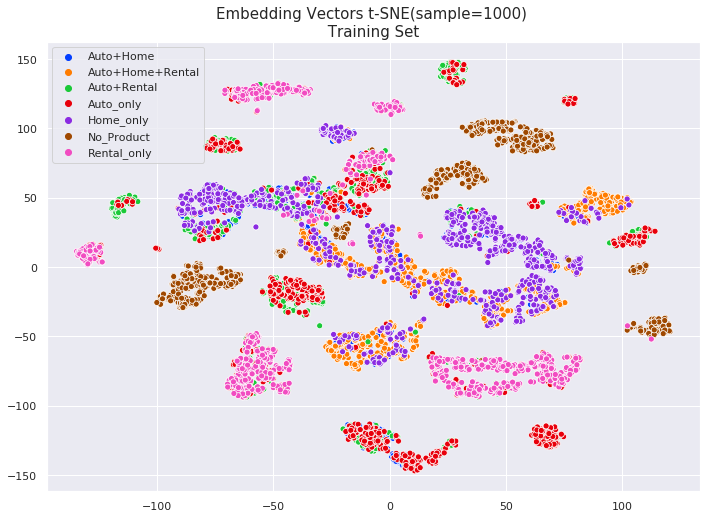

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(train_embedding[:,0], train_embedding[:,1], hue=prod_sample_train.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE(sample=1000) \n Training Set ",fontsize=15)

In [33]:
a,b=np.unique(prod_sample_val,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Validation Set ')

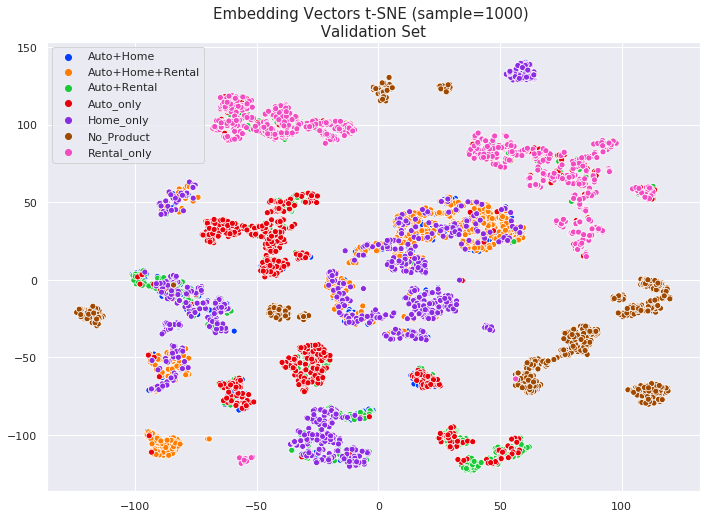

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(val_embedding[:,0], val_embedding[:,1], hue=prod_sample_val.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Validation Set ",fontsize=15)

In [35]:
a,b=np.unique(prod_sample_test,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Test Set ')

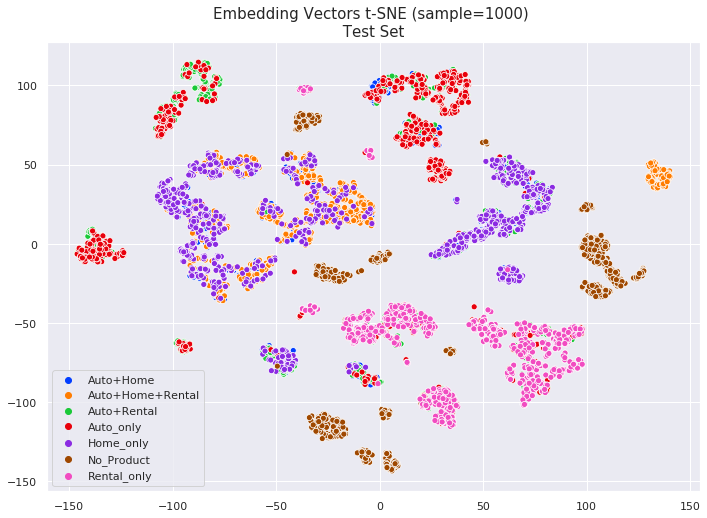

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(test_embedding[:,0], test_embedding[:,1], hue=prod_sample_test.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Test Set ",fontsize=15)

#### score the whole test data instead of minibatch scoring

In [37]:
# logit_val=nn.Linear(args.h_dim, args.out_dim)(th.from_numpy(embedding_vector_val).float())
# label_val=LABEL[7675221:]

# arg1=logit_val[:,1].detach().cpu().numpy()
# arg2=label_val.cpu().numpy()

# gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])

# loss = F.cross_entropy(logit_val, label_val.squeeze(1),weight=th.Tensor([1,args.weight]).to("cpu"))
# acc = th.sum(logit_val.argmax(dim=1) == label_val.squeeze(1)).item()
# precision, recall, fscore, support = score(label_val.squeeze(1).cpu().numpy(), logit_val.argmax(dim=1).cpu().numpy())
# auc = roc_auc_score(label_val.detach().cpu().numpy().ravel(), th.sigmoid(logit_val)[:,1].detach().cpu().numpy().ravel())
# prec,rec,_ = precision_recall_curve(label_val.detach().cpu().numpy().ravel(), th.sigmoid(logit_val)[:,1].detach().cpu().numpy().ravel())
# pr_auc=auc_score(rec,prec)

# # print("loss: {:.3f} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%}"\
# #   .format(loss, prec, recall, fscore, gain["1%"],gain["5%"], gain["10%"], auc, pr_auc))
# print(loss.item(), prec, recall, fscore, gain["1%"],gain["5%"], gain["10%"], auc, pr_auc)

In [38]:
# model_path="/workspace/cjiang/eagle_project/claim_graph/Graph_Model/yearly_KG/Graph_variant/graph_v4/model_param.pt"
# model = Entity_Classify(G,
#                        args.h_dim,
#                        num_classes,
#                        num_bases=args.num_bases,
#                        num_hidden_layers=args.num_layers,
#                        dropout=args.dropout,
#                        use_self_loop=args.use_self_loop)

# if use_cuda:
#     model.cuda()
# model.eval()

# print()
# print("")
# print("Running Validation")
# print("")
# loss_val, prec_val, recall_val, fscore_val, val_gain, val_auc,val_pr_auc = evaluate(model, val_loader,  LABEL, "House_Properties", device)

# print("loss: {:.3f} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%}"\
#   .format(loss_val, prec_val, recall_val, fscore_val, val_gain["1%"],val_gain["5%"], val_gain["10%"], val_auc, val_pr_auc))
    